# Rossman Store Sales Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb 
# Size the plot appropriately for online display
plt.rcParams['figure.figsize'] = (12.0, 10.0)

## Loading the data

We load purely the training set data here.

In [2]:
types = {'StateHoliday': np.dtype(str)}
train = pd.read_csv("./assets/train_v2.csv", parse_dates=[2], nrows=66901, dtype=types)
store = pd.read_csv("./assets/store.csv")

## Data Exploration

We first explore the data to see if we can find any things that can be manually separated.
From scrolling through the columns, we see that there are certain periods where sales are 0 because the stores are closed.
Let's see if this is true.

In [3]:
not_open = train[(train['Open'] == 0) & (train['Sales'] != 0)]
print("No closed store with sales: " + str(not_open.size == 0))

No closed store with sales: True


What about open store but no sales? Are there any?

In [4]:
no_sales = train[(train['Open'] == 1) & (train['Sales'] <= 0)]
print("No open store with no sales: " + str(no_sales.size == 0))

No open store with no sales: True


Seems it is safe then, to remove all our no sales targets to prevent inputting data into graphs.

In [5]:
train = train.loc[train['Sales'] > 0]
assert(train[train['Sales'] == 0].size == 0)

Let's see the range of dates we're looking at here:

In [6]:
dates = pd.to_datetime(train['Date'], format="%Y%m%d:%H:%M:%S.%f").sort_values()
dates = dates.unique()
start_date = dates[0]
end_date = dates[-1]
print("Start date: ", start_date)
print("End Date: ", end_date)
date_range = pd.date_range(start_date, end_date).values
assert(all(dates == date_range))

Start date:  2014-11-26T00:00:00.000000000
End Date:  2015-01-30T00:00:00.000000000


Now let's see the trend for sales per day.

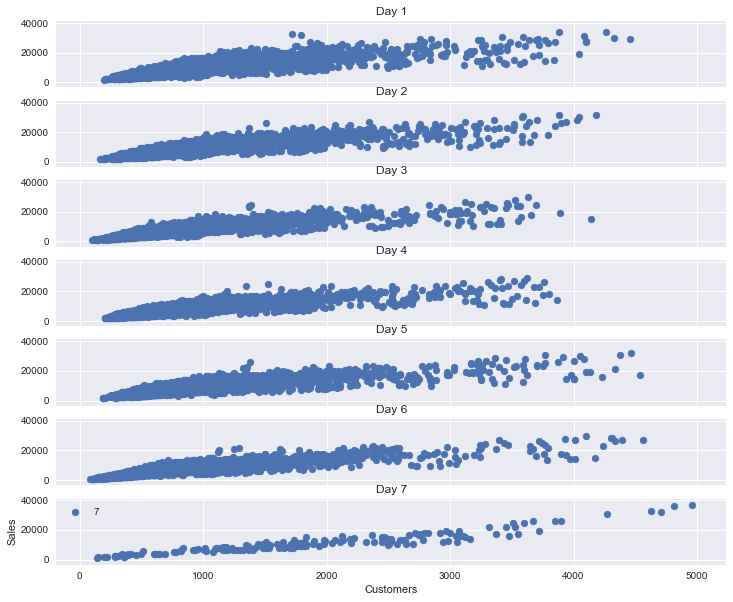

In [7]:
f, ax = plt.subplots(7, sharex=True, sharey=True)
for i in range(1, 8):
    mask = train[train['DayOfWeek'] == i]
    ax[i - 1].set_title("Day {0}".format(i))
    ax[i - 1].scatter(mask['Customers'], mask['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

As we can see, there is a general correlation between sales and customers.

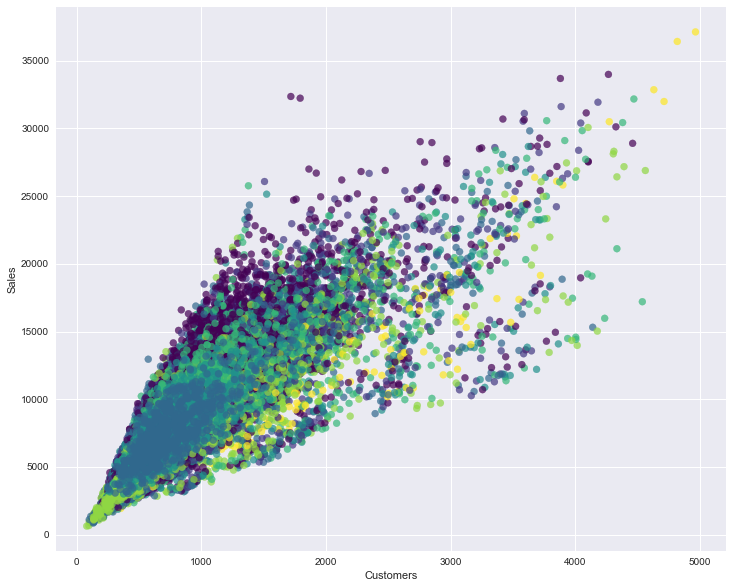

In [8]:
plt.scatter(train['Customers'], train['Sales'], c=train['DayOfWeek'], alpha=0.7, cmap=plt.cm.get_cmap('viridis'))

plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

From above we see that there are various gradients for sales on different days.

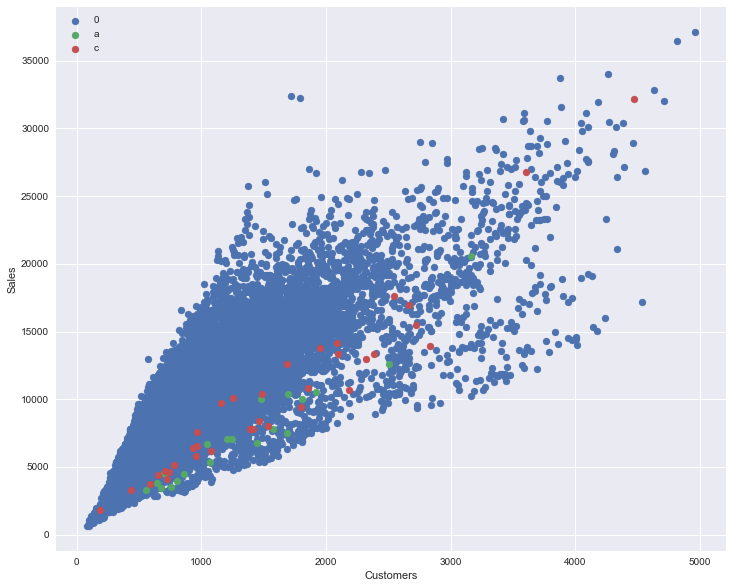

In [9]:
for i in ["0", "a", "b", "c"]:
    data = train[train['StateHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

Interestingly, no easter holiday were found in the test set. This would make any prediction with easter holiday rather inaccurate. We can also see that clearly christmas holidays have more impact than public holidays.

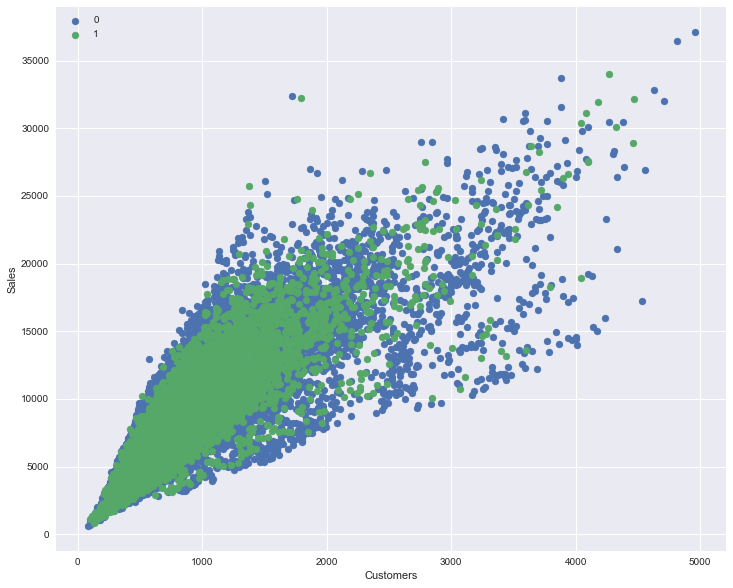

In [10]:
for i in [0, 1]:
    data = train[train['SchoolHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

It appears that school holiday doesn't seem to have much of an impact.

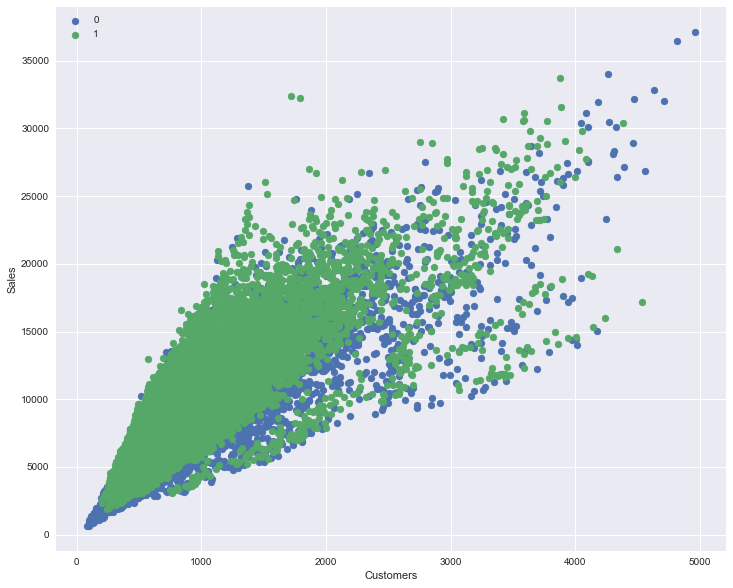

In [11]:
for i in [0, 1]:
    data = train[train['Promo'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

It appears that promos may have some different effects for two groups of stores.

Now let's use the store.csv for more information.

In [12]:
train['SalesPerCustomer'] = train['Sales'] / train['Customers']

avg_store = train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].mean()
avg_store.rename(columns=lambda x: 'Avg' + x, inplace=True)
store = pd.merge(avg_store.reset_index(), store, on='Store')
store.head()

,Store,AvgSales,AvgCustomers,AvgSalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5574.037037,644.407407,8.574182,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5593.407407,602.833333,9.132443,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,7560.740741,797.296296,9.363221,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,10730.296296,1424.888889,7.481731,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5313.981481,564.833333,9.273212,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


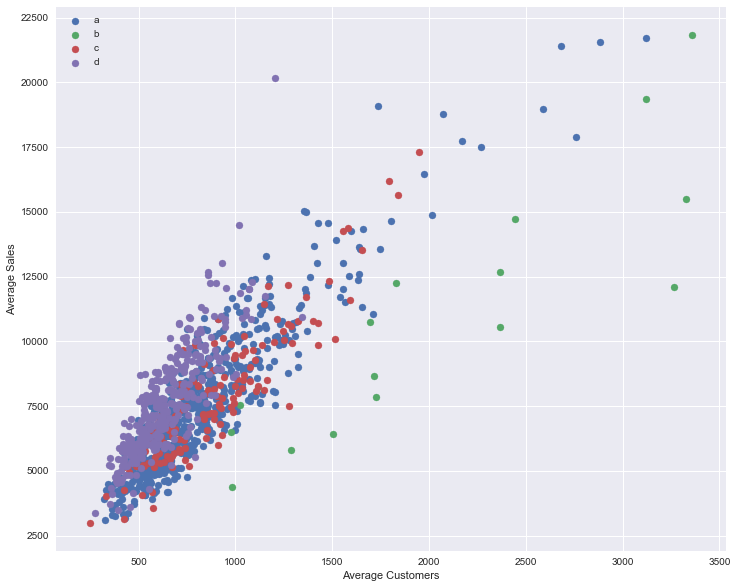

In [13]:
for i in ['a', 'b', 'c', 'd']:
    data = store[store['StoreType'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()

From here we are able to tell that certain store types' customers spend less, like 'b'

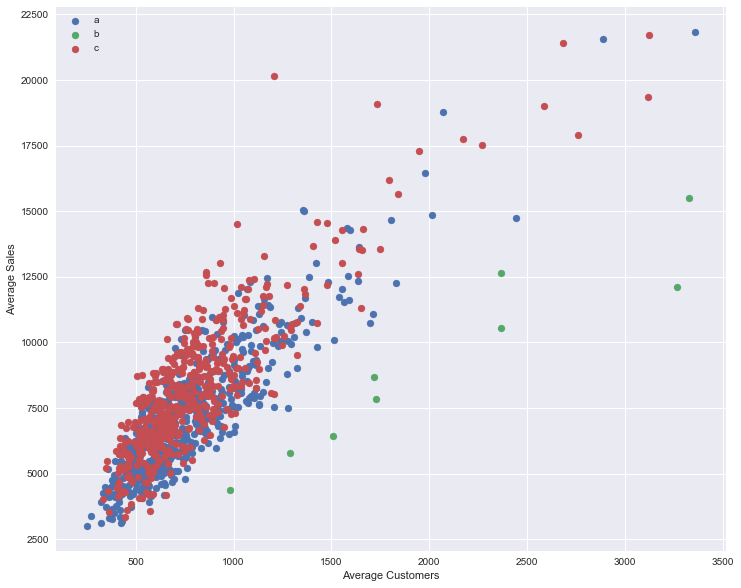

In [14]:
for i in ['a', 'b', 'c']:
    data = store[store['Assortment'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()

From here we are able to tell that certain assortments' customers spend less, like 'b';

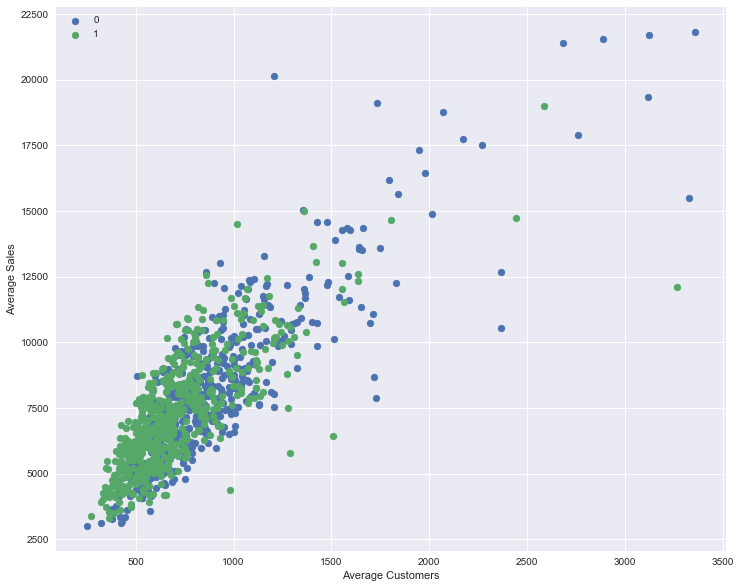

In [15]:
for i in [0, 1]:
    data = store[store['Promo2'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()

It's a bit hard to tell, but it would seem that promo2 would boost sales per customer.

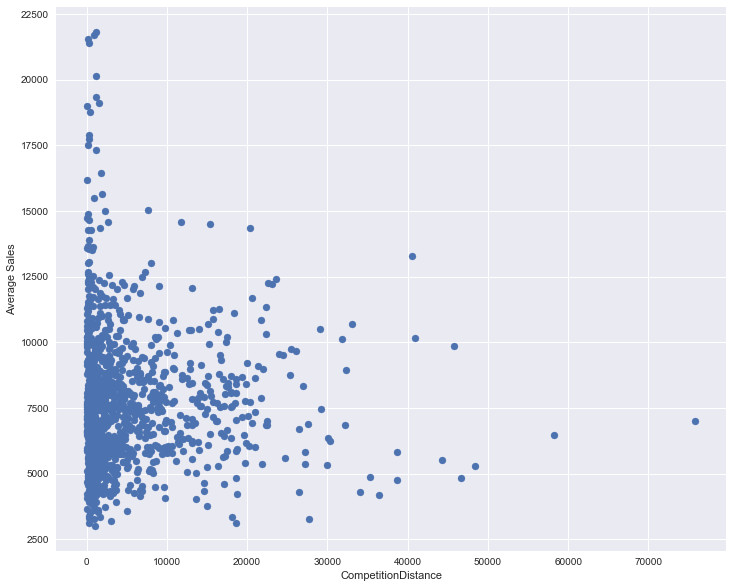

In [16]:
# fill NaN values
store["CompetitionDistance"].fillna(-1)
plt.scatter(store['CompetitionDistance'], store['AvgSales'])

plt.xlabel('CompetitionDistance')
plt.ylabel('Average Sales')
plt.show()

Who knew? Closer competition means more profits.

## Building the model

The first intuition, since there are some distinct separation of scaling due to features such as store type and whether there is a holiday, a decision tree seems to be a good idea.

In [17]:
def build_features(train, store):
    # Convert string types into integers
    store['StoreType'] = store['StoreType'].astype('category').cat.codes
    store['Assortment'] = store['Assortment'].astype('category').cat.codes
    train["StateHoliday"] = train["StateHoliday"].astype('category').cat.codes

    merged = pd.merge(train, store, on='Store', how='left')
    
    # remove NaNs
    NaN_replace = 0
    merged.fillna(NaN_replace, inplace=True)
    
    merged['Year'] = merged.Date.dt.year
    merged['Month'] = merged.Date.dt.month
    merged['Day'] = merged.Date.dt.day
    merged['Week'] = merged.Date.dt.week
    
    # Number of months that competition has existed for
    merged['MonthsCompetitionOpen'] = \
        12 * (merged['Year'] - merged['CompetitionOpenSinceYear']) + \
        (merged['Month'] - merged['CompetitionOpenSinceMonth'])
    merged.loc[merged['CompetitionOpenSinceYear'] ==
               NaN_replace, 'MonthsCompetitionOpen'] = NaN_replace
    
    # Number of weeks that promotion has existed for
    merged['WeeksPromoOpen'] = \
        12 * (merged['Year'] - merged['Promo2SinceYear']) + \
        (merged['Date'].dt.weekofyear - merged['Promo2SinceWeek'])
    merged.loc[merged['Promo2SinceYear'] == 
               NaN_replace, 'WeeksPromoOpen'] = NaN_replace

    toInt = [
        'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear',
        'Promo2SinceWeek', 
        'Promo2SinceYear', 
        'MonthsCompetitionOpen', 
        'WeeksPromoOpen'
    ]
    merged[toInt] = merged[toInt].astype(int)

    return merged

med_store = train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].median()
med_store.rename(columns=lambda x: 'Med' + x, inplace=True)

store = pd.merge(med_store.reset_index(), store, on='Store')
features = build_features(train, store)
features.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,Week,MonthsCompetitionOpen,WeeksPromoOpen
0,1,5,2015-01-30,5577,616,1,1,0,0,9.053571,...,0,0,0,0,2015,1,30,5,76,0
1,2,5,2015-01-30,5919,624,1,1,0,0,9.485577,...,1,13,2010,"Jan,Apr,Jul,Oct",2015,1,30,5,86,52
2,3,5,2015-01-30,6911,678,1,1,0,0,10.193215,...,1,14,2011,"Jan,Apr,Jul,Oct",2015,1,30,5,97,39
3,4,5,2015-01-30,13307,1632,1,1,0,0,8.153799,...,0,0,0,0,2015,1,30,5,64,0
4,5,5,2015-01-30,5640,617,1,1,0,0,9.141005,...,0,0,0,0,2015,1,30,5,-3,0


In [18]:
from sklearn.model_selection import train_test_split
X = [
    'Store', 
    'Customers',
    'CompetitionDistance', 

    'Promo', 
    'Promo2', 

#     'SchoolHoliday',
    'StateHoliday',
    'StoreType',
    'Assortment',

    'AvgSales',
    'AvgCustomers',
    'AvgSalesPerCustomer',
    
    'MedSales',
    'MedCustomers',
    'MedSalesPerCustomer',

    'DayOfWeek',
    'Week',
    'Day',
    'Month',
    'Year',

    'CompetitionOpenSinceMonth',
    'CompetitionOpenSinceYear',
    'Promo2SinceWeek',
    'Promo2SinceYear',

#     'MonthsCompetitionOpen',
#     'WeeksPromoOpen'
]
X_train, X_test, y_train, y_test = train_test_split(
    features[X], features['Sales'], test_size=0.15, random_state=10)

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Error calculating function according to kaggle
def rmspe(y, y_hat):
    return np.sqrt(np.mean(((y - y_hat) / y) ** 2))

rmpse_scorer = make_scorer(rmspe, greater_is_better = False) # Loss function

def score(model, X_train, y_train, y_test, y_hat):
    score = cross_val_score(model, X_train, y_train, scoring=rmpse_scorer, cv=5)
    print('Mean', score.mean())
    print('Variance', score.var())
    print('RMSPE', rmspe(y_test, y_hat))

def plot_importance(model):
    k = list(zip(X, model.feature_importances_))
    k.sort(key=lambda tup: tup[1])

    labels, vals = zip(*k)
    
    plt.barh(np.arange(len(X)), vals, align='center')
    plt.yticks(np.arange(len(X)), labels)

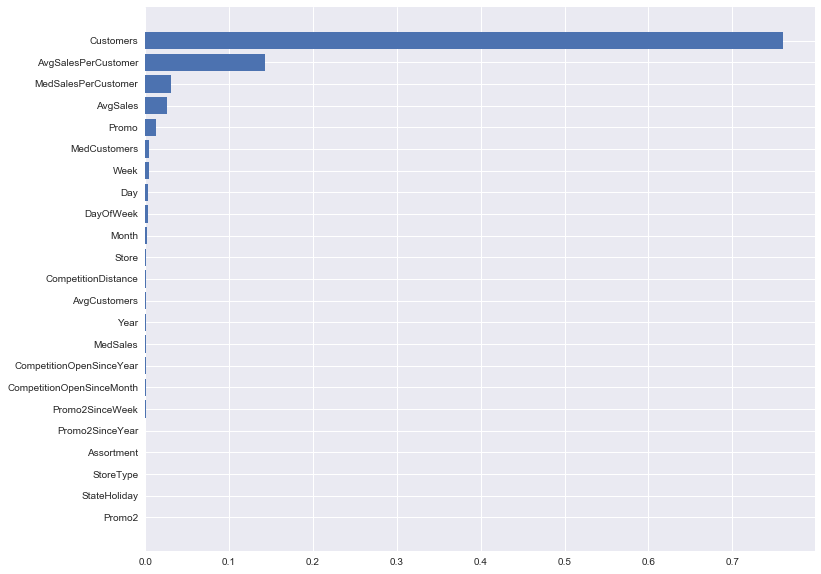

In [20]:
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
plot_importance(decision_tree)

In [21]:
y_hat = decision_tree.predict(X_test)
score(decision_tree, X_train, y_train, y_test, y_hat)

Mean -0.0852200576469
Variance 1.36116186116e-06
RMSPE 0.0820175052062


Let's try some ensemble of decision tree, for example, adaboosting our tree.

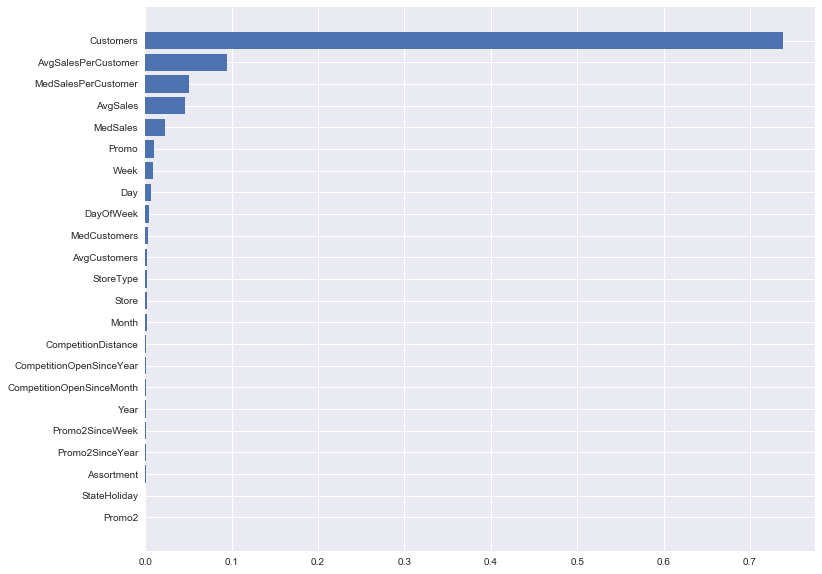

In [22]:
from sklearn.ensemble import AdaBoostRegressor
adaboost_tree = AdaBoostRegressor(DecisionTreeRegressor())
adaboost_tree.fit(X_train, y_train)
plot_importance(adaboost_tree)

In [23]:
y_hat = adaboost_tree.predict(X_test)
score(adaboost_tree, X_train, y_train, y_test, y_hat)

Mean -0.0619261294702
Variance 6.13654833588e-07
RMSPE 0.0609476804549


That is pretty good, how about using RandomForest?

[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.4s finished


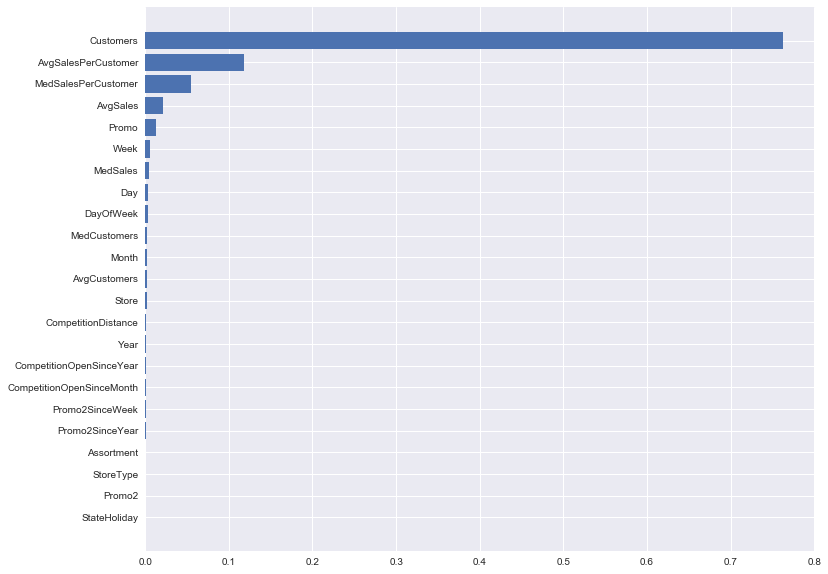

In [24]:
from sklearn.ensemble import RandomForestRegressor
randomForest = RandomForestRegressor(n_estimators=25, n_jobs=-1, verbose=1)
randomForest.fit(X_train, y_train)
plot_importance(randomForest)

In [25]:
y_hat = randomForest.predict(X_test)
score(randomForest, X_train, y_train, y_test, y_hat)

[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Mean -0.0607777455291
Variance 5.79738018284e-07
RMSPE 0.0598913818743


What if we used gradient boosted tree with xgboost?

In [26]:
import xgboost as xgb

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

xgboost_tree = xgb.XGBRegressor(
    n_jobs = -1,
    n_estimators = 1000,
    eta = 0.1,
    max_depth = 2,
    min_child_weight = 2,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.05,
    silent = 0,
    random_state = 1023
)
xgboost_tree.fit(X_train[X], np.log1p(y_train), 
                 eval_set = [(X_train[X], np.log1p(y_train)), (X_test[X], np.log1p(y_test))],
                 eval_metric = rmspe_xg,
                 early_stopping_rounds = 300
                )

[0]	validation_0-rmse:7.5366	validation_1-rmse:7.53599	validation_0-rmspe:0.999568	validation_1-rmspe:0.99957
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 300 rounds.
[1]	validation_0-rmse:6.78394	validation_1-rmse:6.78334	validation_0-rmspe:0.998921	validation_1-rmspe:0.998924
[2]	validation_0-rmse:6.10698	validation_1-rmse:6.10621	validation_0-rmspe:0.99774	validation_1-rmspe:0.997745
[3]	validation_0-rmse:5.49765	validation_1-rmse:5.49682	validation_0-rmspe:0.995737	validation_1-rmspe:0.995747
[4]	validation_0-rmse:4.94896	validation_1-rmse:4.94798	validation_0-rmspe:0.992564	validation_1-rmspe:0.992576
[5]	validation_0-rmse:4.45529	validation_1-rmse:4.4543	validation_0-rmspe:0.987792	validation_1-rmspe:0.98781
[6]	validation_0-rmse:4.01099	validation_1-rmse:4.01011	validation_0-rmspe:0.98097	validation_1-rmspe:0.980997
[7]	validation_0-rmse:3.61125	validation_1-rmse:3.61031	vali

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=2, missing=None,
       n_estimators=1000, n_jobs=-1, nthread=None, objective='reg:linear',
       random_state=1023, reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=0, subsample=0.8, tree_method='exact')

Note that this is not in percentage, thus not to scale of graphs above


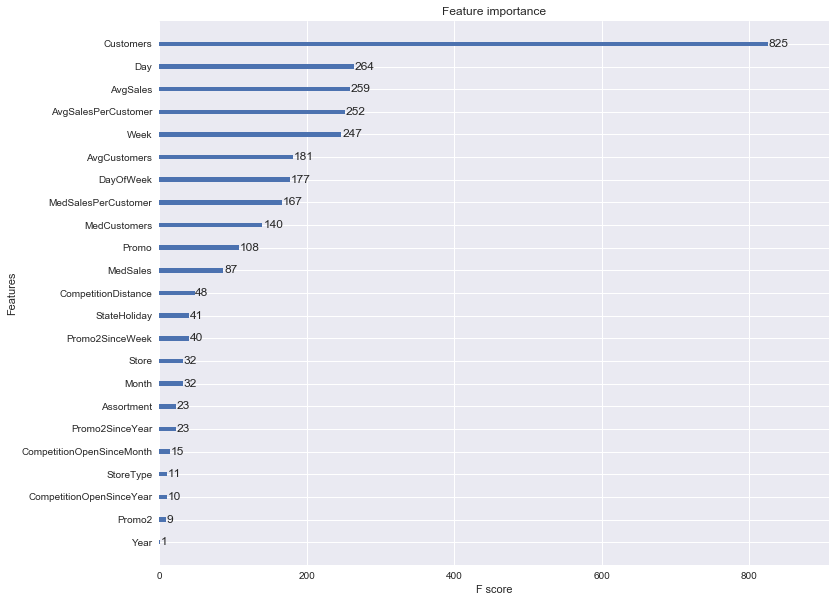

In [27]:
print("Note that this is not in percentage, thus not to scale of graphs above")
xgb.plot_importance(xgboost_tree)

In [28]:
def rmspe_exp(y, y_hat):
    return rmspe(np.expm1(y), np.expm1(y_hat))

rmpse_xg_scorer = make_scorer(rmspe_exp, greater_is_better = False) # Loss function

def score(model, X_train, y_train, y_test, y_hat):
    score = cross_val_score(model, X_train, y_train, scoring=rmpse_xg_scorer, cv=5)
    print('Mean', score.mean())
    print('Variance', score.var())
    print('RMSPE', rmspe(y_test, np.expm1(y_hat)))

y_hat = xgboost_tree.predict(X_test[X])
score(xgboost_tree, X_train[X], np.log1p(y_train), y_test, y_hat)

Mean -0.0554413668092
Variance 1.32385878437e-07
RMSPE 0.0547257476329


Now let's output the real thing:

In [29]:
test = pd.read_csv("./assets/test_v2.csv", parse_dates=[2], dtype=types)
features = build_features(test, store)

y_hat = np.expm1(xgboost_tree.predict(features[X]))

df = pd.DataFrame({"Id": range(1, len(test) + 1), 'Sales': y_hat})
df.loc[test['Open'] == 0, 'Sales'] = 1
df.to_csv('submission.csv', index=False)

Score on leaderboard: 0.6832, 0.6676